In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
import re

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import dre
import rna
import vae
import designers
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-12-09 22:09:48.340968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 22:09:48.340998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 22:09:48.342186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 22:09:48.349445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 22:09:50.033632: W tensorflow/comp

In [175]:
N = 50000
n = 5000
alpha = 0.1
cdf_Nxn1 = np.random.rand(N, n + 1)

t0 = time()
for _ in range(10):
    qidx_N = np.sum(cdf_Nxn1 < 1 - alpha, axis=1)
print(time() - t0)

t0 = time()
for _ in range(10):
    qidx_N = np.array([np.searchsorted(cdf_n1, 1 - alpha) for cdf_n1 in cdf_Nxn1])
print(time() - t0)

3.58353590965271
1.2322945594787598


In [167]:
# test for p-value < alpha / (|Lambda| * N) directly instead of computing p-value
# easy to do this for many target values

def get_weighted_quantiles(scores_n, w_n, w_N, level):
    N = w_N.shape[0]
    # get (unnormalized) density ratio weights for all N unlabeled examples
    # takes 1s out of the 3s to run get_cp_mean_lb
    
    # sort calibration scores and their weights accordingly
    t0 = time()
    idx_n = np.argsort(scores_n)
    sortedscores_n = scores_n[idx_n]
    sortedw_n = w_n[idx_n]
    
    # p_Nxn1: N x (n + 1) matrix of normalized weights
    # each row contains the n weights of the calibration data,
    # plus the weight of one unlabeled example in the last column
    p_Nxn1 = np.hstack([np.tile(sortedw_n[None, :], [N, 1]), w_N[:, None]])
    p_Nxn1 = p_Nxn1 / np.sum(p_Nxn1, axis=1, keepdims=True)  # normalize
    assert(np.all(np.abs(np.sum(p_Nxn1, axis=1) - 1.) < 1e-6))
    
    # locate quantiles of weighted scores for each unlabeled example
    # TODO: parallelize with multiprocessing.dummy (also np.sum?),
    # currently takes 1s out of the 3s to run get_cp_mean_lb
    cdf_Nxn1 = np.cumsum(p_Nxn1, axis=1)
    qidx_N = np.sum(cdf_Nxn1 < level, axis=1)
    
    # catch edge cases when due to floating pt error, np.sum(p_Nxn1, axis=1) is slightly less than 1
    # and also less than level (i.e. for alpha = 1 - 1e-8)
    scoreswithinf_n = np.hstack([sortedscores_n, [np.inf, np.inf]])
    quantile_N = scoreswithinf_n[qidx_N]
    
    return p_Nxn1, quantile_N


def get_cp_mean_lb(ycal_n, predcal_n, w_n, preddesign_N, w_N, alpha: float = 0.1, bonferroni: bool = True):
    # w_n: weights on n labeled inputs
    # w_N: weights on N unlabeled inputs
    
    n = ycal_n.shape[0]
    N = preddesign_N.shape[0]
    print(f'n = {n}, N = {N}')
    
    scores_n = predcal_n - ycal_n  # signed residuals
    level = (1 - alpha / N) if bonferroni else (1 - alpha)
    p_Nxn1, quantile_N = get_weighted_quantiles(scores_n, w_n, w_N, level)
    lb = np.mean(preddesign_N - quantile_N)
    return scores_n, quantile_N, p_Nxn1, lb

def run_cp_hypothesis_test(
    ycal_n, predcal_n, w_n, preddesign_N, w_N, threshold,
    alpha: float = 0.1, bonferroni: bool = True
):
    # if LB computed at level alpha / N is above threshold, then
    # the p-value must be below alpha (for one hypothesis test), so reject. 
    # otherwise, the p-value must be above alpha, so fail to reject.
    _, _, _, lb = get_cp_mean_lb(
        ycal_n, predcal_n, w_n, preddesign_N, w_N, alpha=alpha, bonferroni=bonferroni
    )
    reject = lb > threshold
    return reject


In [13]:
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-ff-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-ff-0.\d',
    'biswas-cnn-0.\d',
    'dbas-ff-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-ff',
    'pex-cnn',
    'dbas-ridge-0.1t\d',
    'dbas-ridge-0.2t\d',
    'cbas-ridge-0.1t\d',
    'cbas-ridge-0.2t\d',
    'cbas-ridge-0.3t\d',
    'cbas-ridge-0.4t\d',
    'cbas-ridge-0.5t\d',
    'cbas-ridge-0.6t\d',
    'cbas-ridge-0.7t\d',
    'cbas-ridge-0.8t\d',
    'cbas-ridge-0.9t\d',
    'cbas-ff-0.1',
    'cbas-ff-0.2',
    'cbas-ff-0.3',
    'cbas-ff-0.4',
    'cbas-ff-0.5',
    'cbas-ff-0.6',
    'cbas-ff-0.7',
    'cbas-ff-0.8',
    'cbas-ff-0.9',
    'cbas-cnn-0.1',
    'cbas-cnn-0.2',
    'cbas-cnn-0.3',
    'cbas-cnn-0.4',
    'cbas-cnn-0.5',
    'cbas-cnn-0.6',
    'cbas-cnn-0.7',
    'cbas-cnn-0.8',
    'cbas-cnn-0.9',
    'vae-ridge'
]

In [18]:
model_and_data_path = '/data/wongfanc/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
calibration_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
trial_idx = 0

# load design sequences
train_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
name2designdata = dre.prepare_name2designdata(
    design_pkl_fname,
    train_fname,
    intermediate_iter_threshold=0.1,
    verbose=False
)

# ----- load models -----
# load training data and fit ridge regression
d = np.load(train_fname)
trainseqs_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=utils.RNA_NUCLEOTIDES)
ridge.fit(trainseqs_n, ytrain_n)

# load trained FF and CNN models
ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, utils.RNA_NUCLEOTIDES, 100)
ff.load(ff_fname)
cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, utils.RNA_NUCLEOTIDES, 32, 100)
cnn.load(cnn_fname)
name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

mdre = dre.MultiMDRE(
    mdre_group_regex_strs,
    device=torch.device('cuda')
)


# load calibration data
with open(calibration_pkl_fname, 'rb') as f:
    caldata_t = pickle.load(f)
    
# load labeled calibration sequences from training distribution
calseqs_n, ycal_n = caldata_t[trial_idx]
name2designdata['train'] = (trainseqs_n + calseqs_n, np.hstack([ytrain_n, ycal_n]), None)

# get predictions for calibration sequences
name2predcal = {name: model.predict(calseqs_n) for name, model in name2model.items()}

# fit density ratio estimator (DRE) for all design algorithms
mdre.fit(name2designdata, n_hidden=500, n_epoch=100, verbose=True)

No design data for dbas-ridge-0.3t0, exiting.
No design data for dbas-ridge-0.4t0, exiting.
No design data for dbas-ridge-0.5t0, exiting.
No design data for dbas-ridge-0.6t0, exiting.
No design data for dbas-ridge-0.7t0, exiting.
No design data for dbas-ridge-0.8t0, exiting.
No design data for dbas-ridge-0.9t0, exiting.
Fitting MDRE for adalead-ridge-0.\d, which has 11 design algorithms:
train
adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
adalead-ridge-0.45
adalead-ridge-0.35
adalead-ridge-0.25
adalead-ridge-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (10 s)


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.97it/s]


Min train loss 1.57, min val loss 1.54

Fitting MDRE for adalead-ff-0.\d, which has 11 design algorithms:
train
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
adalead-ff-0.45
adalead-ff-0.35
adalead-ff-0.25
adalead-ff-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (10 s)


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.11it/s]


Min train loss 1.51, min val loss 1.48

Fitting MDRE for adalead-cnn-0.\d, which has 11 design algorithms:
train
adalead-cnn-0.5
adalead-cnn-0.4
adalead-cnn-0.3
adalead-cnn-0.2
adalead-cnn-0.1
adalead-cnn-0.05
adalead-cnn-0.01
adalead-cnn-0.45
adalead-cnn-0.35
adalead-cnn-0.25
adalead-cnn-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (9 s)


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.10it/s]


Min train loss 1.50, min val loss 1.46

Fitting MDRE for biswas-ridge-0.\d, which has 4 design algorithms:
train
biswas-ridge-0.02
biswas-ridge-0.01
biswas-ridge-0.005
biswas-ridge-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (4 s)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.81it/s]


Min train loss 0.99, min val loss 0.99

Fitting MDRE for biswas-ff-0.\d, which has 4 design algorithms:
train
biswas-ff-0.02
biswas-ff-0.01
biswas-ff-0.005
biswas-ff-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


Min train loss 0.99, min val loss 0.99

Fitting MDRE for biswas-cnn-0.\d, which has 4 design algorithms:
train
biswas-cnn-0.02
biswas-cnn-0.01
biswas-cnn-0.005
biswas-cnn-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.69it/s]


Min train loss 1.01, min val loss 1.03

Fitting MDRE for dbas-ff-0.\d, which has 9 design algorithms:
train
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (8 s)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


Min train loss 1.61, min val loss 1.57

Fitting MDRE for dbas-cnn-0.\d, which has 9 design algorithms:
train
dbas-cnn-0.1
dbas-cnn-0.2
dbas-cnn-0.3
dbas-cnn-0.4
dbas-cnn-0.5
dbas-cnn-0.6
dbas-cnn-0.7
dbas-cnn-0.8
dbas-cnn-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (8 s)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]


Min train loss 1.71, min val loss 1.67

Fitting MDRE for pex-ridge, which has 1 design algorithms:
train
pex-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.01it/s]


Min train loss 0.24, min val loss 0.26

Fitting MDRE for pex-ff, which has 1 design algorithms:
train
pex-ff
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.49it/s]


Min train loss 0.24, min val loss 0.27

Fitting MDRE for pex-cnn, which has 1 design algorithms:
train
pex-cnn
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.17it/s]


Min train loss 0.27, min val loss 0.29

Fitting MDRE for dbas-ridge-0.1t\d, which has 1 design algorithms:
train
dbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 79.31it/s]


Min train loss 0.47, min val loss 0.52

Fitting MDRE for dbas-ridge-0.2t\d, which has 1 design algorithms:
train
dbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.52it/s]


Min train loss 0.03, min val loss 0.05

Fitting MDRE for cbas-ridge-0.1t\d, which has 1 design algorithms:
train
cbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 85.83it/s]


Min train loss 0.57, min val loss 0.64

Fitting MDRE for cbas-ridge-0.2t\d, which has 1 design algorithms:
train
cbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 77.88it/s]


Min train loss 0.56, min val loss 0.62

Fitting MDRE for cbas-ridge-0.3t\d, which has 1 design algorithms:
train
cbas-ridge-0.3t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.77it/s]


Min train loss 0.54, min val loss 0.62

Fitting MDRE for cbas-ridge-0.4t\d, which has 1 design algorithms:
train
cbas-ridge-0.4t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 72.68it/s]


Min train loss 0.51, min val loss 0.57

Fitting MDRE for cbas-ridge-0.5t\d, which has 1 design algorithms:
train
cbas-ridge-0.5t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.57it/s]


Min train loss 0.48, min val loss 0.55

Fitting MDRE for cbas-ridge-0.6t\d, which has 1 design algorithms:
train
cbas-ridge-0.6t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 81.95it/s]


Min train loss 0.44, min val loss 0.50

Fitting MDRE for cbas-ridge-0.7t\d, which has 1 design algorithms:
train
cbas-ridge-0.7t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 88.53it/s]


Min train loss 0.37, min val loss 0.42

Fitting MDRE for cbas-ridge-0.8t\d, which has 1 design algorithms:
train
cbas-ridge-0.8t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 88.13it/s]


Min train loss 0.22, min val loss 0.24

Fitting MDRE for cbas-ridge-0.9t\d, which has 1 design algorithms:
train
cbas-ridge-0.9t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 82.14it/s]


Min train loss 0.02, min val loss 0.02

Fitting MDRE for cbas-ff-0.1, which has 1 design algorithms:
train
cbas-ff-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.55it/s]


Min train loss 0.57, min val loss 0.67

Fitting MDRE for cbas-ff-0.2, which has 1 design algorithms:
train
cbas-ff-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.75it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-ff-0.3, which has 1 design algorithms:
train
cbas-ff-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 92.00it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.4, which has 1 design algorithms:
train
cbas-ff-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 84.45it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.5, which has 1 design algorithms:
train
cbas-ff-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 87.14it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-ff-0.6, which has 1 design algorithms:
train
cbas-ff-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.25it/s]


Min train loss 0.59, min val loss 0.66

Fitting MDRE for cbas-ff-0.7, which has 1 design algorithms:
train
cbas-ff-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.94it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.8, which has 1 design algorithms:
train
cbas-ff-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.32it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-ff-0.9, which has 1 design algorithms:
train
cbas-ff-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.23it/s]


Min train loss 0.58, min val loss 0.66

Fitting MDRE for cbas-cnn-0.1, which has 1 design algorithms:
train
cbas-cnn-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 92.13it/s]


Min train loss 0.58, min val loss 0.67

Fitting MDRE for cbas-cnn-0.2, which has 1 design algorithms:
train
cbas-cnn-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 87.17it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.3, which has 1 design algorithms:
train
cbas-cnn-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.96it/s]


Min train loss 0.60, min val loss 0.66

Fitting MDRE for cbas-cnn-0.4, which has 1 design algorithms:
train
cbas-cnn-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.69it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.5, which has 1 design algorithms:
train
cbas-cnn-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.61it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.6, which has 1 design algorithms:
train
cbas-cnn-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.85it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-cnn-0.7, which has 1 design algorithms:
train
cbas-cnn-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 86.08it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.8, which has 1 design algorithms:
train
cbas-cnn-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 83.74it/s]


Min train loss 0.58, min val loss 0.68

Fitting MDRE for cbas-cnn-0.9, which has 1 design algorithms:
train
cbas-cnn-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.56it/s]


Min train loss 0.60, min val loss 0.66

Fitting MDRE for vae-ridge, which has 1 design algorithms:
train
vae-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.89it/s]

Min train loss 0.63, min val loss 0.69



In [164]:
design_name = 'vae-ridge'
(designseq_n, ydesign_n, preddesign_N) = name2designdata[design_name]

# ----- quantities for prediction-powered test -----
imputed_mean = np.mean(preddesign_N)
imputed_se = np.std(preddesign_N) / np.sqrt(preddesign_N.size)

# predictions for calibration sequences
predcal_n =  ridge.predict(calseqs_n)

# DRs for calibration sequences
caldr_n = mdre.get_dr(calseqs_n, design_name, self_normalize=True, verbose=False)

# rectifier sample mean and standard error
rect_n = caldr_n * (ycal_n - predcal_n)
rectifier_mean = np.mean(rect_n)
rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
print(
    '{:.4f}, {:.4f}, {:.4f}'.format(
        np.mean(ydesign_n), np.mean(preddesign_N), np.mean(preddesign_N) + rectifier_mean
    )
)

0.2850, 0.2848, 0.2850


In [166]:
alpha = 0.1
bonferroni = False
t0 = time()
scores_n, quantile_N, p_Nxn1, lb = get_cp_mean_lb(
    ycal_n, predcal_n, caldr_n, designseq_n, preddesign_N,
    lambda x: mdre.get_dr(x, design_name, self_normalize=True, verbose=False),
    alpha=alpha, bonferroni=bonferroni
)
print(lb)
print(time() - t0)

n = 5000, N = 50000
0.2562432049781961
3.147296190261841


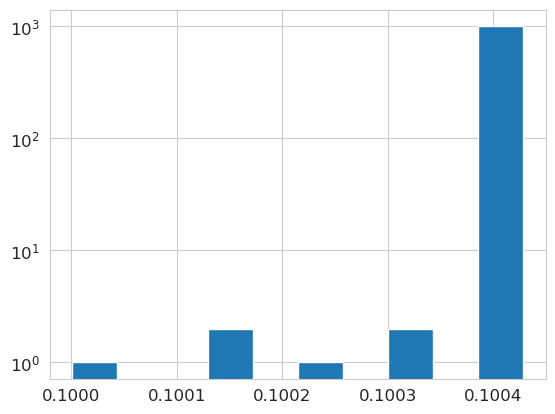

In [163]:
cdf_Nxn1 = np.cumsum(p_Nxn1, axis=1)
qidx_N = np.sum(cdf_Nxn1 < 1 - 0.9, axis=1)
plt.hist([cdf_Nxn1[i, j] for i, j in zip(range(N), qidx_N)], log=True);

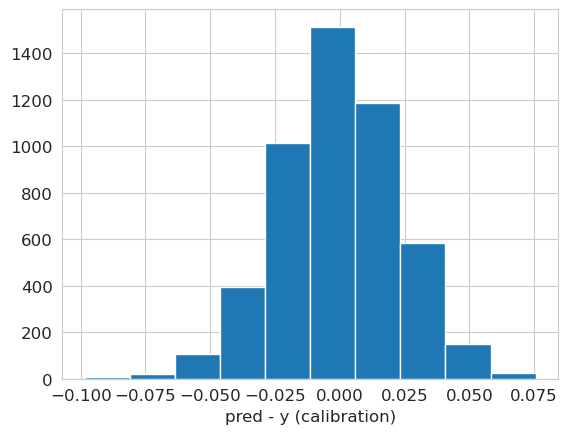

In [67]:
plt.hist(scores_n);
plt.xlabel('pred - y (calibration)');

# sandbox run_pp_selection_experiments

In [2]:
# cannot contain any groups that don't have any data from name2designdata
# MDRE.fit() will throw error
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-ff-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-ff-0.\d',
    'biswas-cnn-0.\d',
    'dbas-ff-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-ff',
    'pex-cnn',
    'dbas-ridge-0.1t\d',
    'dbas-ridge-0.2t\d',
    'cbas-ridge-0.1t\d',
    'cbas-ridge-0.2t\d',
    'cbas-ridge-0.3t\d',
    'cbas-ridge-0.4t\d',
    'cbas-ridge-0.5t\d',
    'cbas-ridge-0.6t\d',
    'cbas-ridge-0.7t\d',
    'cbas-ridge-0.8t\d',
    'cbas-ridge-0.9t\d',
    'cbas-ff-0.1',
    'cbas-ff-0.2',
    'cbas-ff-0.3',
    'cbas-ff-0.4',
    'cbas-ff-0.5',
    'cbas-ff-0.6',
    'cbas-ff-0.7',
    'cbas-ff-0.8',
    'cbas-ff-0.9',
    'cbas-cnn-0.1',
    'cbas-cnn-0.2',
    'cbas-cnn-0.3',
    'cbas-cnn-0.4',
    'cbas-cnn-0.5',
    'cbas-cnn-0.6',
    'cbas-cnn-0.7',
    'cbas-cnn-0.8',
    'cbas-cnn-0.9',
    'vae-ridge'
]

In [ ]:
reload(dre)
reload(utils)
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
# cbas ridge
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')

# dbas ridge
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
    

design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
cal_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
target_values = np.arange(0.25, 0.501, 0.001)
n_trial = 200
n_mdre_hidden = 512
n_mdre_epoch = 500
pp_csv_fname = '/data/wongfanc/rna-results/selection-pp-120924.csv'
cp_csv_fname = '/data/wongfanc/rna-results/selection-cp-120924.csv'
device = torch.device('cuda')

df = rna.run_pp_selection_experiments(
    design_names,
    design_pkl_fname,
    model_and_data_fname_no_ftype,
    cal_pkl_fname,
    mdre_group_regex_strs,
    target_values,
    n_trial,
    n_mdre_hidden=n_mdre_hidden,
    n_mdre_epoch=n_mdre_epoch,
    pp_csv_fname=pp_csv_fname,
    cp_csv_fname=cp_csv_fname,
    device=device,
)

No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.7t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.8t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.9t0, exiting MDRE select_intermediate_iterations.
All design names in provided design data:
cbas-ridge-0.1t19
cbas-ridge-0.2t19
cbas-ridge-0.3t19
cbas-ridge-0.4t19
cbas-ridge-0.5t19
cbas-ridge-0.6t19
cbas-ridge-0.7t19
cbas-ridge-0.8t19
cbas-ridge-0.9t19
dbas-ridge-0.1t19
dbas-ridge-0.2t19
adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
pex-ridge
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
ada

100%|████████████████████████████████████████████████████| 500/500 [05:37<00:00,  1.48it/s]


Min train loss 0.77, min val loss 0.58

Fitting MDRE for adalead-ff-0.\d, which has 11 design algorithms:
train
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
adalead-ff-0.45
adalead-ff-0.35
adalead-ff-0.25
adalead-ff-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (8 s)


100%|████████████████████████████████████████████████████| 500/500 [05:38<00:00,  1.48it/s]


Min train loss 0.81, min val loss 0.66

Fitting MDRE for adalead-cnn-0.\d, which has 11 design algorithms:
train
adalead-cnn-0.5
adalead-cnn-0.4
adalead-cnn-0.3
adalead-cnn-0.2
adalead-cnn-0.1
adalead-cnn-0.05
adalead-cnn-0.01
adalead-cnn-0.45
adalead-cnn-0.35
adalead-cnn-0.25
adalead-cnn-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (8 s)


100%|████████████████████████████████████████████████████| 500/500 [05:38<00:00,  1.48it/s]


Min train loss 0.90, min val loss 0.79

Fitting MDRE for biswas-ridge-0.\d, which has 4 design algorithms:
train
biswas-ridge-0.02
biswas-ridge-0.01
biswas-ridge-0.005
biswas-ridge-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.36it/s]


Min train loss 0.84, min val loss 1.00

Fitting MDRE for biswas-ff-0.\d, which has 4 design algorithms:
train
biswas-ff-0.02
biswas-ff-0.01
biswas-ff-0.005
biswas-ff-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.37it/s]


Min train loss 0.84, min val loss 1.00

Fitting MDRE for biswas-cnn-0.\d, which has 4 design algorithms:
train
biswas-cnn-0.02
biswas-cnn-0.01
biswas-cnn-0.005
biswas-cnn-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.36it/s]


Min train loss 0.84, min val loss 1.08

Fitting MDRE for dbas-ff-0.\d, which has 9 design algorithms:
train
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (7 s)


 13%|██████▉                                              | 66/500 [00:32<03:34,  2.02it/s]